In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from sklearn.model_selection import train_test_split
import configparser

%matplotlib inline

#### Model Selection
Before deploying a model the first step is to select a model that can perform regression form rental prices based on the data in the database

First extract the data from the database

In [5]:
parser = configparser.ConfigParser()
parser.read("../data/credentials.ini")

['../data/credentials.ini']

In [6]:
engine = create_engine(URL.create(**parser["DATABASE"]))
query = """
SELECT *
FROM ml_training_data;
"""
df = pd.read_sql(query, engine)
df = df.dropna()
df["district_name"] = df["district_name"].astype("category")

In [7]:
df.head()

,district_name,construction_year,rooms,area,price
0,Altstadt,1937.0,2.0,90.0,1800.0
1,Altstadt,1937.0,2.0,90.0,1800.0
2,Altstadt,1844.0,3.0,136.0,2920.0
3,Altstadt,1844.0,3.0,136.0,2920.0
4,Altstadt,1908.0,4.0,252.0,8500.0


In [8]:
df.describe()

,construction_year,rooms,area,price
count,730.000000,730.000000,730.000000,730.000000
mean,1969.750685,2.593151,80.859904,1201.706767
std,56.242428,0.987345,41.062064,972.016599
min,1198.000000,1.000000,14.000000,300.000000
25%,1955.000000,2.000000,57.000000,698.000000
50%,1972.000000,2.500000,72.570000,947.160000
75%,2000.000000,3.000000,94.000000,1400.000000
max,2024.000000,7.000000,340.000000,8500.000000


array([[<Axes: xlabel='construction_year', ylabel='construction_year'>,
        <Axes: xlabel='rooms', ylabel='construction_year'>,
        <Axes: xlabel='area', ylabel='construction_year'>,
        <Axes: xlabel='price', ylabel='construction_year'>],
       [<Axes: xlabel='construction_year', ylabel='rooms'>,
        <Axes: xlabel='rooms', ylabel='rooms'>,
        <Axes: xlabel='area', ylabel='rooms'>,
        <Axes: xlabel='price', ylabel='rooms'>],
       [<Axes: xlabel='construction_year', ylabel='area'>,
        <Axes: xlabel='rooms', ylabel='area'>,
        <Axes: xlabel='area', ylabel='area'>,
        <Axes: xlabel='price', ylabel='area'>],
       [<Axes: xlabel='construction_year', ylabel='price'>,
        <Axes: xlabel='rooms', ylabel='price'>,
        <Axes: xlabel='area', ylabel='price'>,
        <Axes: xlabel='price', ylabel='price'>]], dtype=object)

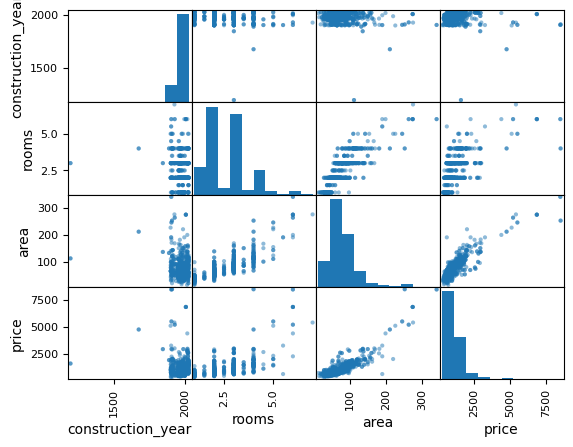

In [9]:
pd.plotting.scatter_matrix(df)

Looks like all the variables have an influence on the price, which seems reasonable. 
Before training the model we need to extract feature- and target variables

In [12]:
X_raw = df.drop("price", axis=1)
y = df.price

Since "district_name" is categorical we need to introduce dummy variables. 
This is done by the DictVectorizer

In [13]:
transformer = DictVectorizer()

X = transformer.fit_transform(X_raw.to_dict("records"))

Now split the data in training and test data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Maybe the influence from the scatter plots can be described by a linear model so lets train a linear regression model on the data

In [16]:
model = LinearRegression()
model.fit(X=X_train, y=y_train)

LinearRegression()

In [17]:
model.score(X_train, y_train)

0.8571760526597952

In [18]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

323.1984616704189

<Axes: >

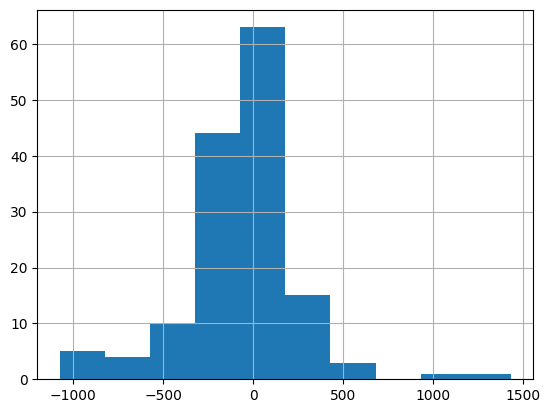

In [19]:
res = y_test - y_pred
res.hist()

The score looks pretty good and the residuals seem to be normal distributed which gives a clue that everything that can not be described by the model is just random noise.
But since the variance is very high, maybe another regression model could explain the dependence structure better.
So lets train a random forrest regression. 

In [20]:
from sklearn.ensemble import RandomForestRegressor

forrest = RandomForestRegressor()
forrest.fit(X_train, y_train)

RandomForestRegressor()

In [21]:
forrest.score(X_train, y_train)

0.9824608135434217

In [22]:
forrest.score(X_test, y_test)

0.9196140506755206

In [23]:
y_pred = forrest.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

270.73187837103677

-39.86386647260269


<Axes: >

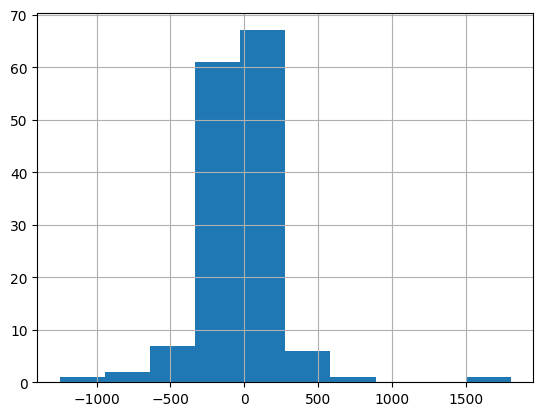

In [24]:
res = y_test - y_pred
res.hist()

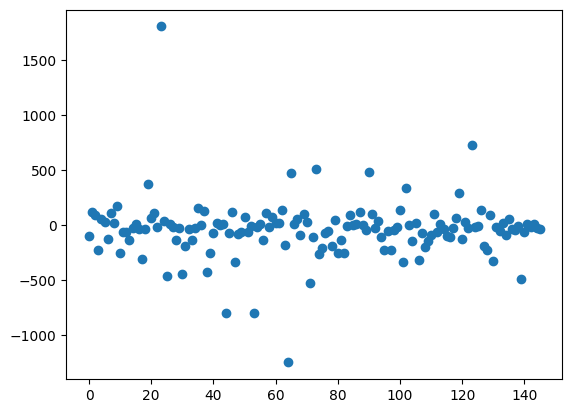

In [25]:
import matplotlib.pyplot as plt

plt.scatter(x=range(len(res)), y=res)

Here we have as well normal distributed residuals but since the scores are a bit higher an the residuals have a smaller variance I would prefer the random forrest over the linear regression model.


The final model looks like the following:

In [27]:
from sklearn.pipeline import Pipeline

final_model = Pipeline(
    [("transformer", DictVectorizer()), ("tree", RandomForestRegressor())]
)

final_model.fit(X_raw.to_dict("records"), y)

Pipeline(steps=[('transformer', DictVectorizer()),
                ('tree', RandomForestRegressor())])

In [28]:
final_model.score(X_raw.to_dict("records"), y)

0.9848547111239931